# Navigating a human assembly with gfabase

This notebook demonstrates using gfabase to import (i) a **GFA** human *de novo* assembly graph, and (ii) **PAF** mappings of its segments to the reference genome. With these indexed together in a .gfab file, gfabase can then rapidly query for subgraphs associated with reference genome coordinates, reading only the necessary parts of the file. The subgraphs can be visualized with [Bandage](https://rrwick.github.io/Bandage/), or feed any other downstream analysis.

Prerequisites: SQLite library 3.31.0+, which is a relatively new version, and `aria2c` (fast download tool).

* Linux:
  * If it's inconvenient to upgrade the host SQLite package, [gfabase Releases](https://github.com/mlin/gfabase/releases) include a pre-built `libsqlite3.so.0` to place alongside `gfabase`
  * The `aria2` package provides `aria2c` for most distributions
* macOS: `brew install sqlite3 aria2`

**First, fetching `gfabase` executable:**

In [1]:
%%bash
# substitute "linux" for "macOS" if appropriate:
aria2c -c -q -o gfabase https://github.com/mlin/gfabase/releases/download/v0.4.0-pre.0/gfabase-macOS-x86-64
chmod +x gfabase
./gfabase version | grep gfabase

gfabase release v0.4.0-pre.0 2021-01-20T08:49:25+00:00


**Downloading a [Shasta](https://github.com/chanzuckerberg/shasta) GFA assembled from HG002 ONT reads, and the minimap2 PAF of its segments & GRCh38.**

In [2]:
%%bash
aria2c -c -q -o Assembly.gfa -s 16 -x 16 --retry-wait 2 \
    https://s3-us-west-2.amazonaws.com/czi.paolo-public/HG002-Guppy-3.6.0-run4-UL/Assembly.gfa
aria2c -c -q -o Alignments-NoCigar.paf -s 16 -x 16 --retry-wait 2 \
    https://s3-us-west-2.amazonaws.com/czi.paolo-public/HG002-Guppy-3.6.0-run4-UL/mapToHg38/Alignments-NoCigar.tsv

Grab a coffee for this ~5GB download; subsequently, aria2c will be smart enough not to repeat it.

## .gfa to .gfab

Use `gfabase load` to generate `Assembly.gfab` from `Assembly.gfa`:

In [3]:
%%bash
./gfabase --verbose load -o Assembly.gfab Assembly.gfa
ls -lh Assembly.gfa*

-rw-r--r--  1 mlin  staff   4.8G Jan 19 23:45 Assembly.gfa
-rw-r--r--  1 mlin  staff   1.2G Jan 20 15:08 Assembly.gfab


[DEBUG][0.0s] deleting if present: Assembly.gfab
[DEBUG][0.1s] created GFA1 tables
[DEBUG][0.1s] processing GFA1 records...
[INFO][29.0s] processed 30977 GFA1 record(s)
[DEBUG][29.0s] writing segment metadata...
[DEBUG][29.0s] insertions complete
[INFO][29.0s] indexing...
[DEBUG][29.0s] 	CREATE UNIQUE INDEX gfa1_segment_name ...
[DEBUG][29.0s] 	CREATE INDEX gfa1_segment_mapping_segment ...
[DEBUG][29.0s] 	CREATE INDEX gfa1_link_from_to ...
[DEBUG][29.0s] 	CREATE INDEX gfa1_link_to_from ...
[DEBUG][29.0s] 	CREATE INDEX gfa1_containment_container_contained ...
[DEBUG][29.0s] 	CREATE INDEX gfa1_containment_contained_container ...
[DEBUG][29.0s] 	CREATE UNIQUE INDEX gfa1_path_name ...
[DEBUG][29.0s] 	CREATE INDEX gfa1_path_segment ...
[DEBUG][29.0s] 	indexing segment mappings by genomic range ...
[DEBUG][29.0s] 	indexing graph connectivity ...
[DEBUG][29.1s] 	ANALYZE ...
[DEBUG][29.6s] flushing Assembly.gfab ...
[DEBUG][40.9s] tables & row counts:
[DEBUG][40.9s] 	gfa1_segment_meta	12,520
[

The .gfab file is nicely compressed in under a minute (YMMV), and we get some interesting details about the encoded graph. `gfabase view Assembly.gfab` dumps it back to plain GFA.

Note: `gfabase load` expects uncompressed GFA input, but we could stream a `.gfa.gz` e.g.

```bash
gunzip -c Assembly.gfa.gz | ./gfabase load -o Assembly.gfab
```

## .gfab += .paf

Add the GRCh38 .paf mappings to the .gfab; include only the mappings of 1Kbp+, since we're just looking for a skeleton for navigation.

In [4]:
%%bash
./gfabase add-mappings Assembly.gfab Alignments-NoCigar.paf --length 1000 --replace

[INFO][0.7s] inserted 64837 of 72114 mappings


*  Don't have .paf mappings handy for your assembly? see [our example WDL pipeline](https://github.com/mlin/gfabase/blob/main/workflows/gfab_winnowmap.wdl) to generate some with [Winnowmap](https://github.com/marbl/Winnowmap).
* `--replace` makes the command idempotent by deleting any existing mappings stored in the .gfab
* the .gfab is updated in-place, so make a backup copy first if needed

## Extracting a subgraph

Now we can use the key command `gfabase sub` to have a look at the assembly graph topology around the HLA locus on chromosome 6.

In [5]:
%%bash
time ./gfabase sub Assembly.gfab chr6:29,700,000-29,950,000 --range --view --cutpoints 2 --no-sequences --guess-ranges

H	VN:Z:1.0	PG:Z:gfabase-v0.4.0-pre.0
S	436	*	LN:i:847359	RC:i:14769725	gr:Z:chr6:28,547,540-29,393,181
S	1340	*	LN:i:270142	RC:i:9677097	gr:Z:chr6:29,393,168-29,663,210
S	1774	*	LN:i:433368	RC:i:12407133	gr:Z:chr6:31,619,091-32,051,947
S	3358	*	LN:i:847930	RC:i:14183904	gr:Z:chr6:28,547,540-29,393,181
S	4488	*	LN:i:226932	RC:i:7139070	gr:Z:chr6_GL000252v2_alt:1,744,865-1,971,466
S	7528	*	LN:i:80224	RC:i:2690736	gr:Z:chr6:28,467,310-28,547,552
S	22514	*	LN:i:903941	RC:i:17171676	gr:Z:chr6:30,715,602-31,619,104
S	22515	*	LN:i:899619	RC:i:18401254	gr:Z:chr6:30,715,602-31,619,104
S	23310	*	LN:i:815596	RC:i:14913340	gr:Z:chr6:29,663,193-30,489,045
S	23311	*	LN:i:816717	RC:i:13208210	gr:Z:chr6:29,663,193-30,489,045
L	436	-	1340	+	13M
L	436	+	7528	+	12M
L	1340	-	3358	+	13M
L	1340	+	23310	-	17M
L	1340	+	23311	-	17M
L	1774	+	22514	+	13M
L	1774	+	22515	+	13M
L	3358	+	7528	+	12M
L	4488	+	22514	-	13M
L	4488	+	22515	-	13M
L	4488	-	23310	+	12M
L	4488	-	23311	+	12M


[INFO][0.1s] guessed ranges for 10 segments

real	0m0.146s
user	0m0.012s
sys	0m0.008s


* `--range`: interpret each positional argument as a reference genomic range to search in the segment mappings, instead of a GFA segment name
* `--view`: output plain .gfa instead of a sub-gfab
* `--cutpoints 2`: extract the graph neighborhood of segments mapped to the specified genomic range
  * specifically: starting from the segments with directly-overlapping mappings, crawl all segments reachable by crossing fewer than two *cutpoints* ("articulation points") of the undirected segment graph
  * lets us see any interesting graph topology associated with the reference range, without loading the whole connected component (chromosome)
* `--no-sequences`: exclude the DNA sequences, for succinct display here
* `--guess-ranges`: add the `gr:Z` tags with genomic ranges "guessed" from the segments' PAF mappings (imprecise, for rough navigation only)

Notice the operation was nearly instantaneous, which makes it easy to go exploring wherever you like.

## Visualizing subgraph with Bandage

`gfabase sub` can send the selected subgraph directly to [Bandage](https://rrwick.github.io/Bandage/) for visualization, so we can quickly inspect regions of interest without loading the whole graph. (`gfabase view` can send everything, if desired.)

To proceed, make sure the `Bandage` executable is available in the effective `$PATH`. 
  * macOS: `export PATH=/path/to/Bandage.app/Contents/MacOS:$PATH`

In [6]:
%%bash
./gfabase sub Assembly.gfab -o HG002-HLA.gfa chr6:29,700,000-29,950,000 --range --cutpoints 2 --guess-ranges --bandage

[INFO][0.1s] guessed ranges for 10 segments
[INFO][0.1s] wrote CSV with guessed segment ranges to HG002-HLA.guessed_ranges.csv
[INFO][0.1s] Bandage load HG002-HLA.gfa --draw


With `--guess-ranges --bandage`, this also generates a CSV file for Bandage to load (*File > Load CSV data*) annotating each segment's guessed range.

Here's what we should see, clearly showing where Shasta was and wasn't able to resolve HG002's two haplotypes. In this case, the non-resolved segments serve as the "cutpoints" delimiting the extracted subgraph, including one that seems to best match an ALT contig of GRCh38.

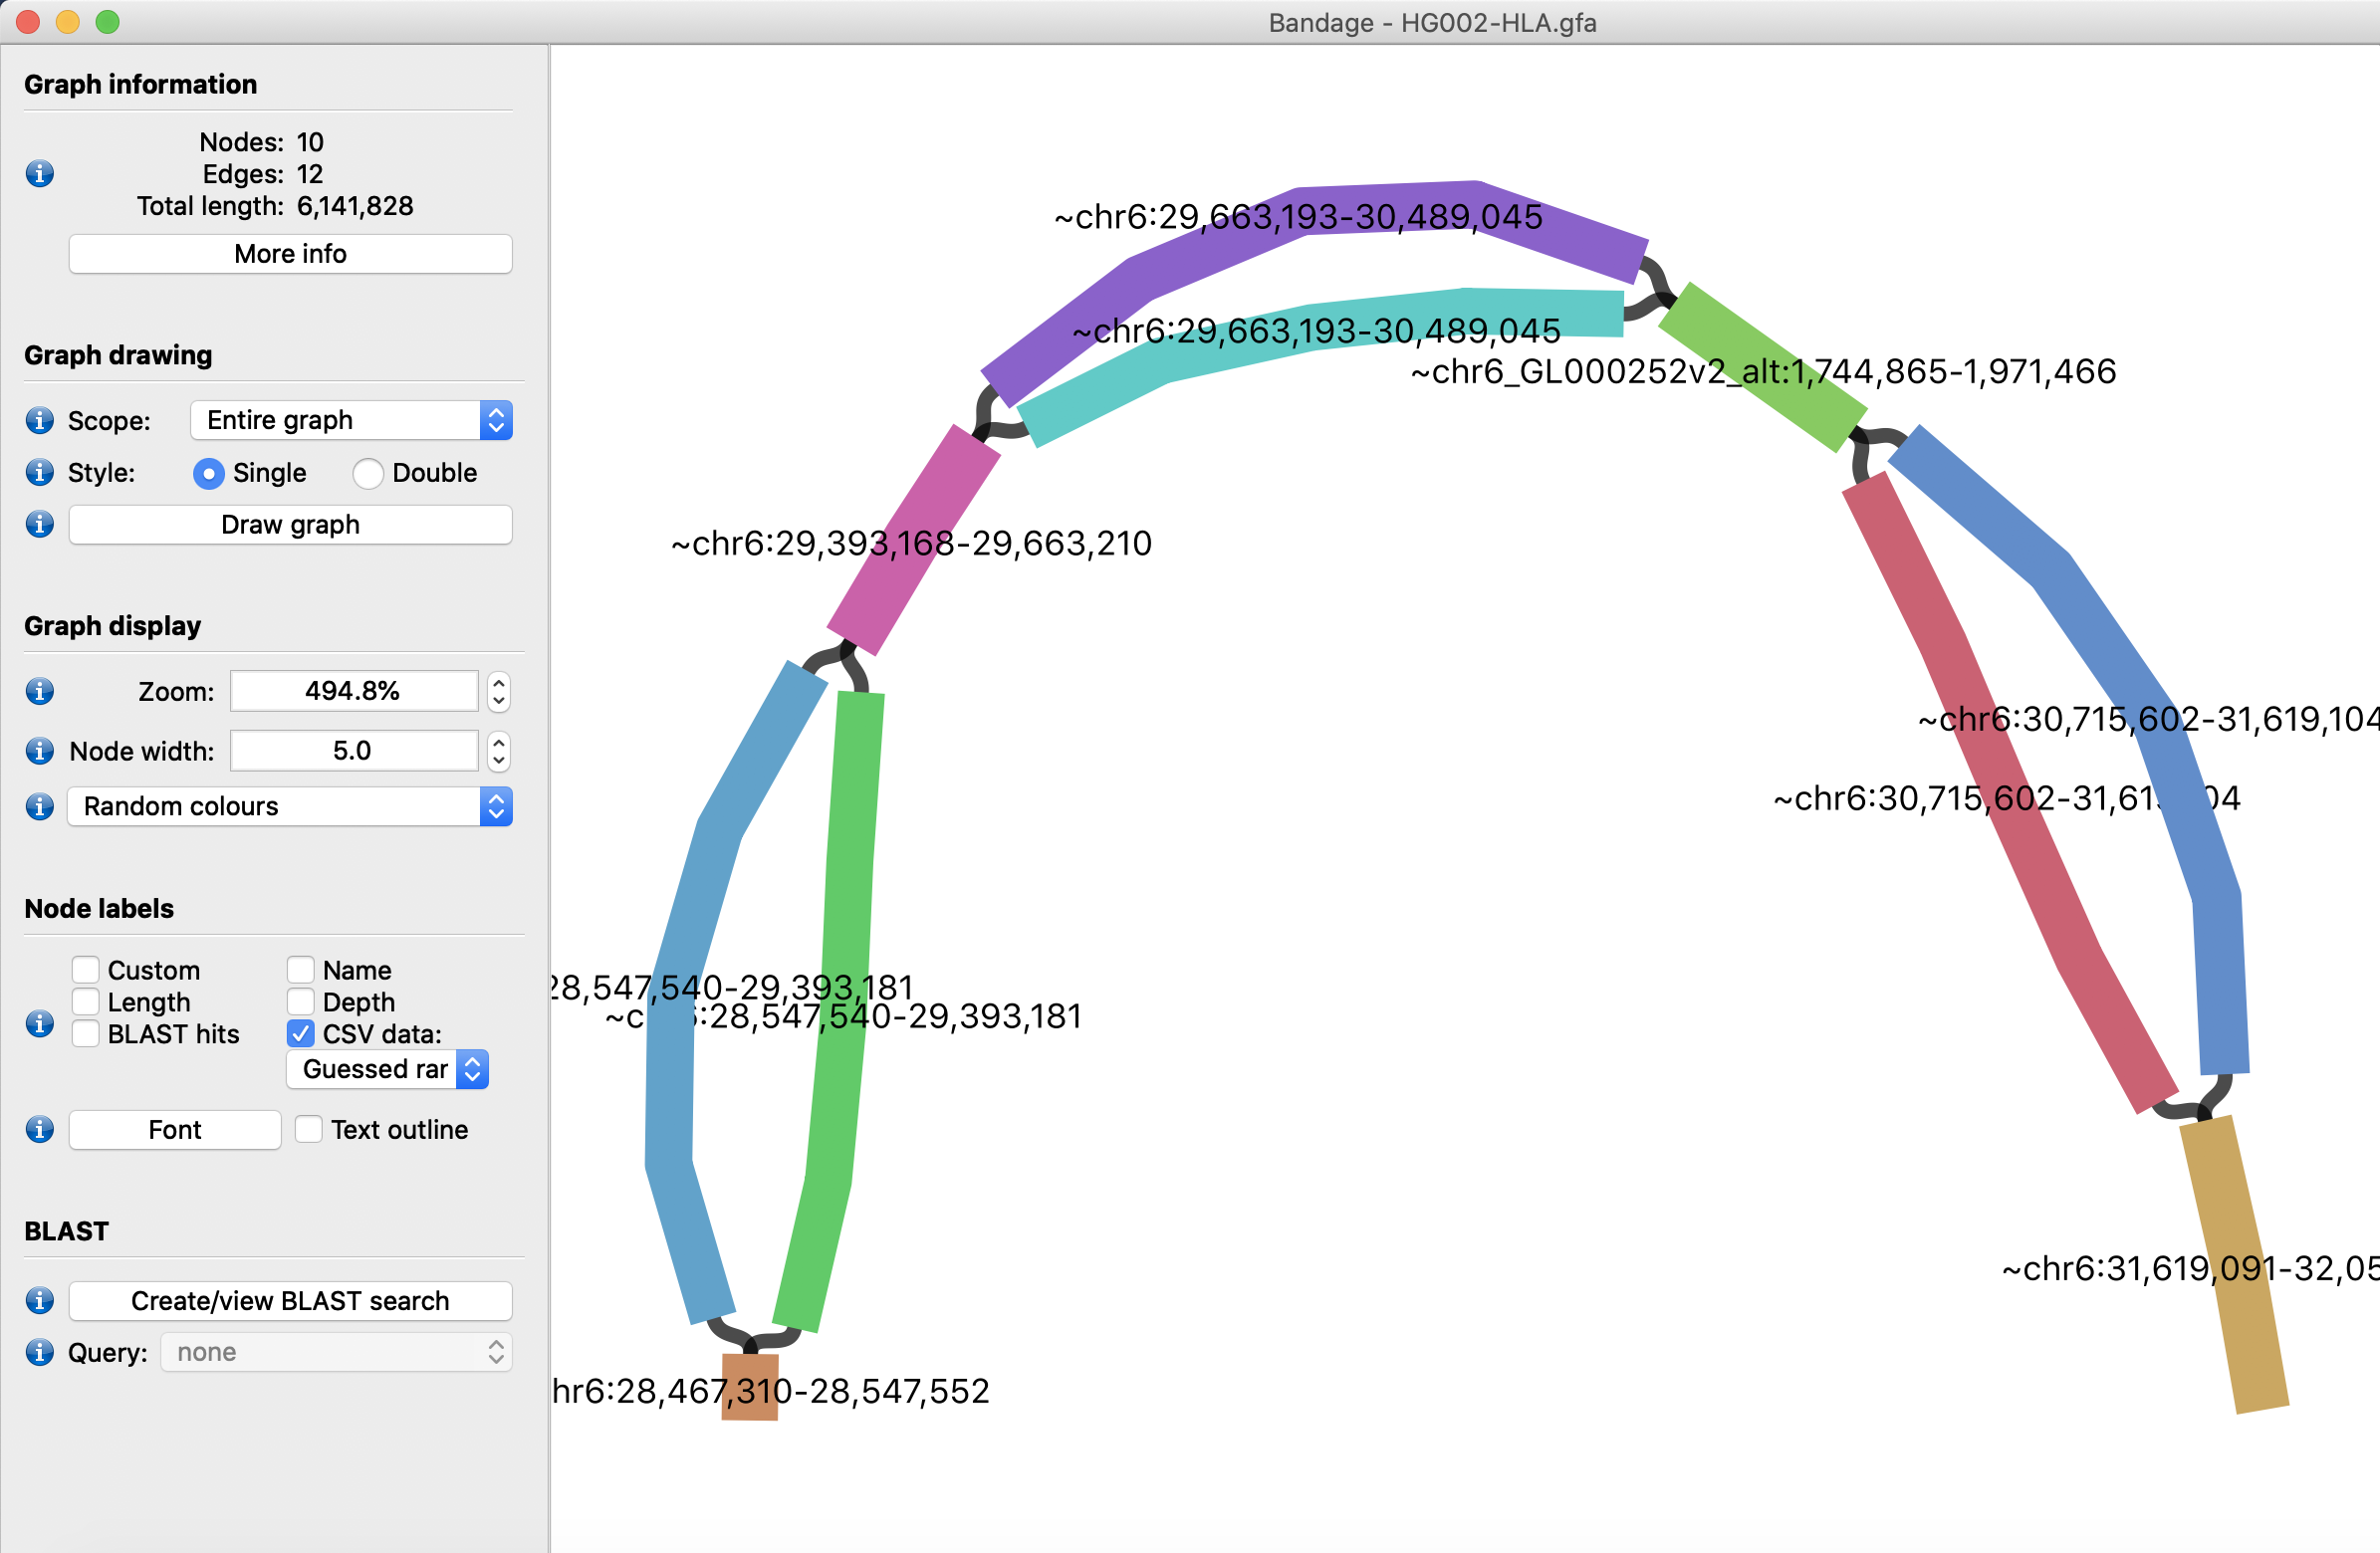

Much more can be done to integrate Bandage and gfabase in the future. We are just starting out here.

## Opening .gfab programmatically

A .gfab file is actually a SQLite (+ [Genomics Extension](https://github.com/mlin/GenomicSQLite)) database; we can open and query its [schema](https://github.com/mlin/gfabase/tree/main/src/schema) directly. With `pip3 install genomicsqlite`:

In [8]:
import genomicsqlite

db = genomicsqlite.connect("Assembly.gfab", read_only=True)
next(db.execute("SELECT count(*) FROM gfa1_segment_meta"))[0]

12520

In [9]:
list(db.execute("""
select substr(twobit_dna(sequence_twobit),0,100) || '...' from gfa1_segment_sequence where segment_id in
    (select distinct segment_id from gfa1_segment_mapping where _rowid_ in
       genomic_range_rowids('gfa1_segment_mapping', 'chr6', 29700000, 29950000)
     order by segment_id);
"""))

[('AGCCAAGATCGTGCCATTGCCCTCCAGCCTGGGCAACAAGAAAAAAAGAAATTAGTGAGGACCCAAATAAATTTTGTTTCTGTGGATTGTATCAATTTT...',),
 ('AGCCAAGATCGTGCCATTGCCCTCCAGCCTGGGCAACAAGAAAAAAGAAATTAGTGAGGACCCAAATAAATTTTGTTTCTGTGGATTGTATCAATTTTT...',)]

In exchange for the steeper learning curve, this approach can be still much more efficient, as data indices are cached in memory to serve successive queries.